# Read CCSM4 model data

In [1]:
import xarray as xr

path='D:/VScode/Paleoclimate_causality/CCSM4_ANN_data/cesmi6gat31rblc200_ANN_210912_998911_cam2_decclimots.nc'

ds=xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:          (lev: 26, ilev: 27, time: 788, lat: 48, lon: 96, nbnd: 2)
Coordinates:
  * lev              (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * ilev             (ilev) float64 2.194 4.895 9.882 ... 956.0 985.1 1e+03
  * time             (time) object 2114-12-16 00:00:00 ... 9984-12-16 00:00:00
  * lat              (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon              (lon) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
Dimensions without coordinates: nbnd
Data variables: (12/142)
    hyam             (lev) float64 ...
    hybm             (lev) float64 ...
    hyai             (ilev) float64 ...
    hybi             (ilev) float64 ...
    P0               float64 ...
    date             (time) int32 ...
    ...               ...
    VQ               (time, lev, lat, lon) float32 ...
    VT               (time, lev, lat, lon) float32 ...
    VU               (time, lev, lat, lon) float32 ...
    VV               (time, lev, lat, lon) float32 ...
    Z3               (time, lev, lat, lon) float32 ...
    time_bnds        (time, nbnd) object ...
Attributes: (12/18)
    Conventions:               CF-1.0
    source:                    CAM
    case:                      cesmi6gat31rblc200
    title:                     UNSET
    logname:                   guido
    host:                      c9-13.local
    ...                        ...
    climo_command:             '/home/guido/anaconda3/bin/ncclimo -L 1 -c ces...
    climo_hostname:            c3-16
    climo_version:             4.7.4
    yrs_averaged:              2110-2119
    NCO:                       netCDF Operators version 4.8.0 (Homepage = htt...
    nco_openmp_thread_number:  1

# Extract TEMP

In [2]:
import xarray as xr
import numpy as np

# Extracting the 'TREFHT' variable into a new DataArray
ds = ds['TREFHT']

# Creating a new dataset with just the 'TREFHT' variable
ds = ds.to_dataset()
# Get the length of the current 'time' dimension
num_times = ds.dims['time']

# Create a new time variable starting from 0, increasing in steps of 10
new_time = np.arange(0, num_times * 10, 10)

# Assign this new time variable to the 'time' coordinate of your dataset
ds['time'] = new_time

mean_data = ds['TREFHT'].mean(dim='time')

# Subtract the mean from the data
ds['TREFHT_centered'] = ds['TREFHT'] - mean_data



weight = np.cos(np.deg2rad(ds['lat']))
print('shape of the weight:', weight.shape)

# Set weight to 0 if it is smaller than 0
weight = xr.where(weight < 0, 0, weight)

# Add the weight to the dataset
ds['weight'] = weight

# Multiply 'sat_centered' with the weight
ds['TREFHT_c_w']  = ds['TREFHT_centered'] * weight





# ds.info
ds


shape of the weight: (48,)


<xarray.Dataset>
Dimensions:          (time: 788, lat: 48, lon: 96)
Coordinates:
  * time             (time) int32 0 10 20 30 40 50 ... 7830 7840 7850 7860 7870
  * lat              (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon              (lon) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
Data variables:
    TREFHT           (time, lat, lon) float32 212.5 212.3 212.0 ... 227.6 227.7
    TREFHT_centered  (time, lat, lon) float32 0.08495 0.09824 ... -0.7201
    weight           (lat) float64 0.04956 0.1136 0.1775 ... 0.1136 0.04956
    TREFHT_c_w       (time, lat, lon) float64 0.00421 0.004869 ... -0.03569

# Plot

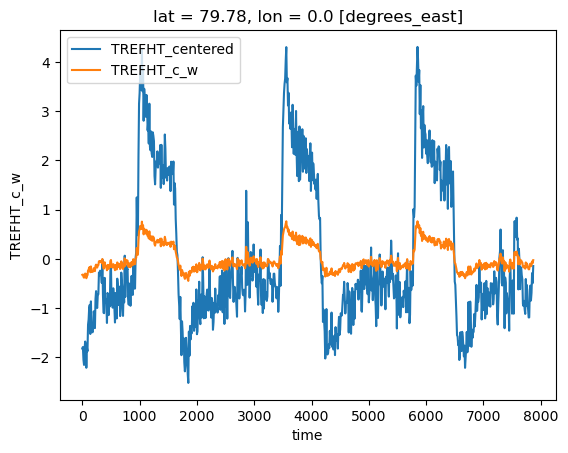

In [3]:
# ds.isel(lat=45, lon=0).TREFHT.plot()
ds.isel(lat=45, lon=0).TREFHT_centered.plot()
ds.isel(lat=45, lon=0).TREFHT_c_w.plot()
# add legend
import matplotlib.pyplot as plt
plt.legend(['TREFHT_centered', 'TREFHT_c_w'])

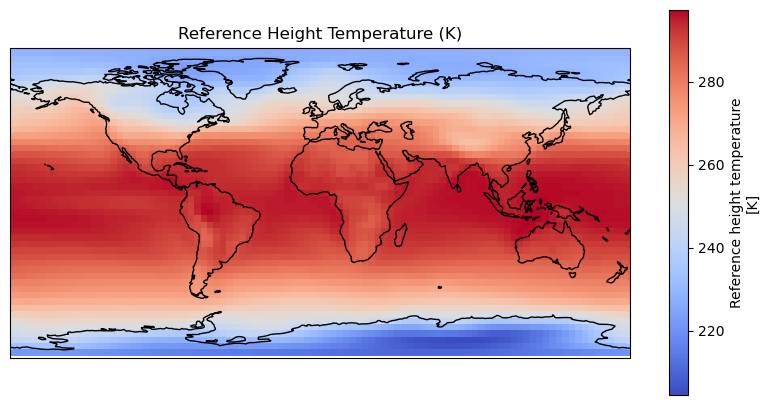

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



# Plotting the first value of time for TREFHT on a real world map
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.TREFHT.isel(time=0).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=True)
ax.coastlines()
ax.set_global()
plt.title('Reference Height Temperature (K)')
plt.show()


In [5]:
# rename the TREFHT to sat
ds = ds.rename({'TREFHT': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})

# convert the sat to degrees C
ds['sat'] = ds['sat'] - 273.15

In [8]:
# save the ds
ds.to_netcdf('data/CCSM4_TEMP.nc')

# Load processed data

In [9]:
# load the ds
import xarray as xr

ds = xr.open_dataset('data/CCSM4_TEMP.nc')
ds

<xarray.Dataset>
Dimensions:          (age: 788, lat: 48, lon: 96)
Coordinates:
  * age              (age) int32 0 10 20 30 40 50 ... 7830 7840 7850 7860 7870
  * lat              (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon              (lon) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
Data variables:
    sat              (age, lat, lon) float32 ...
    TREFHT_centered  (age, lat, lon) float32 ...
    weight           (lat) float64 ...
    TREFHT_c_w       (age, lat, lon) float64 ...

# PCA

shape of the weight: (48,)
shape of the reshaped sat_centered_weighted: (788, 4608)


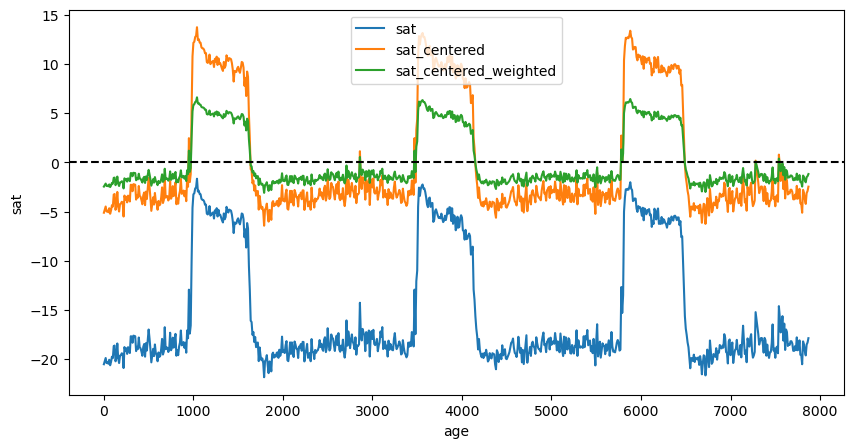

In [6]:
from toolbox import PCA_functions as pf

ds_sat=ds
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
# Assuming you want to plot data for lat=0 and lon=0
lat_index = 40
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)

In [7]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_variance, eofs, pcs = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_variance)


shape of the reshaped sat_centered_weighted: (4608, 788)
shape of u, s, vh: (4608, 4608) (788,) (788, 788)
shape of EOFs: (4608, 2)
shape of PCs: (788, 2)
Explained variance: [8.76342993e-01 3.58420890e-02 1.43367524e-02 9.14674115e-03
 6.05640829e-03 4.34295505e-03 4.01346876e-03 3.21790557e-03
 2.77465013e-03 2.16873947e-03 2.00911290e-03 1.78662277e-03
 1.71608039e-03 1.50388643e-03 1.30135508e-03 1.25494979e-03
 1.20405830e-03 1.07298781e-03 1.01673644e-03 9.87173572e-04
 9.54760127e-04 9.04865610e-04 8.22221335e-04 7.65758976e-04
 7.12393828e-04 6.52312744e-04 6.44756278e-04 6.10296666e-04
 5.89227646e-04 5.50755389e-04 5.33249226e-04 4.94464369e-04
 4.65143191e-04 4.39115776e-04 4.29980864e-04 4.22720572e-04
 4.11176746e-04 4.03622509e-04 3.84041714e-04 3.59994365e-04
 3.49572577e-04 3.39920245e-04 3.35248905e-04 3.25952324e-04
 3.11414384e-04 3.06954573e-04 2.81241836e-04 2.79464093e-04
 2.69525560e-04 2.63669961e-04 2.52930799e-04 2.40519943e-04
 2.39012857e-04 2.34975216e-04 2

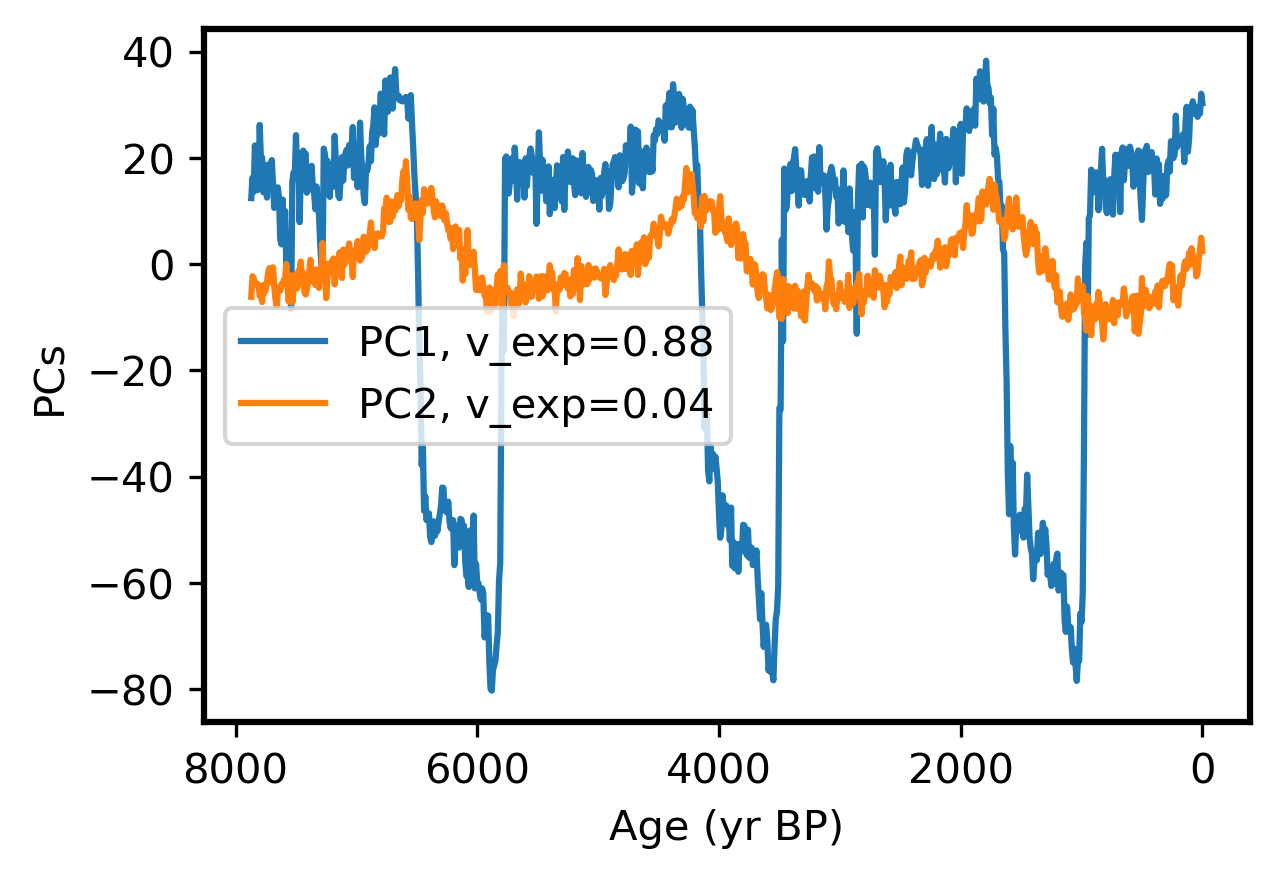

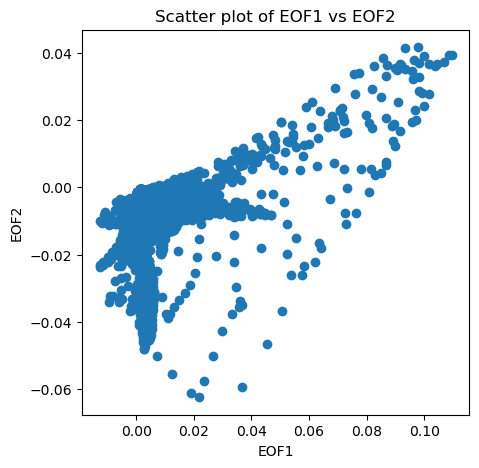

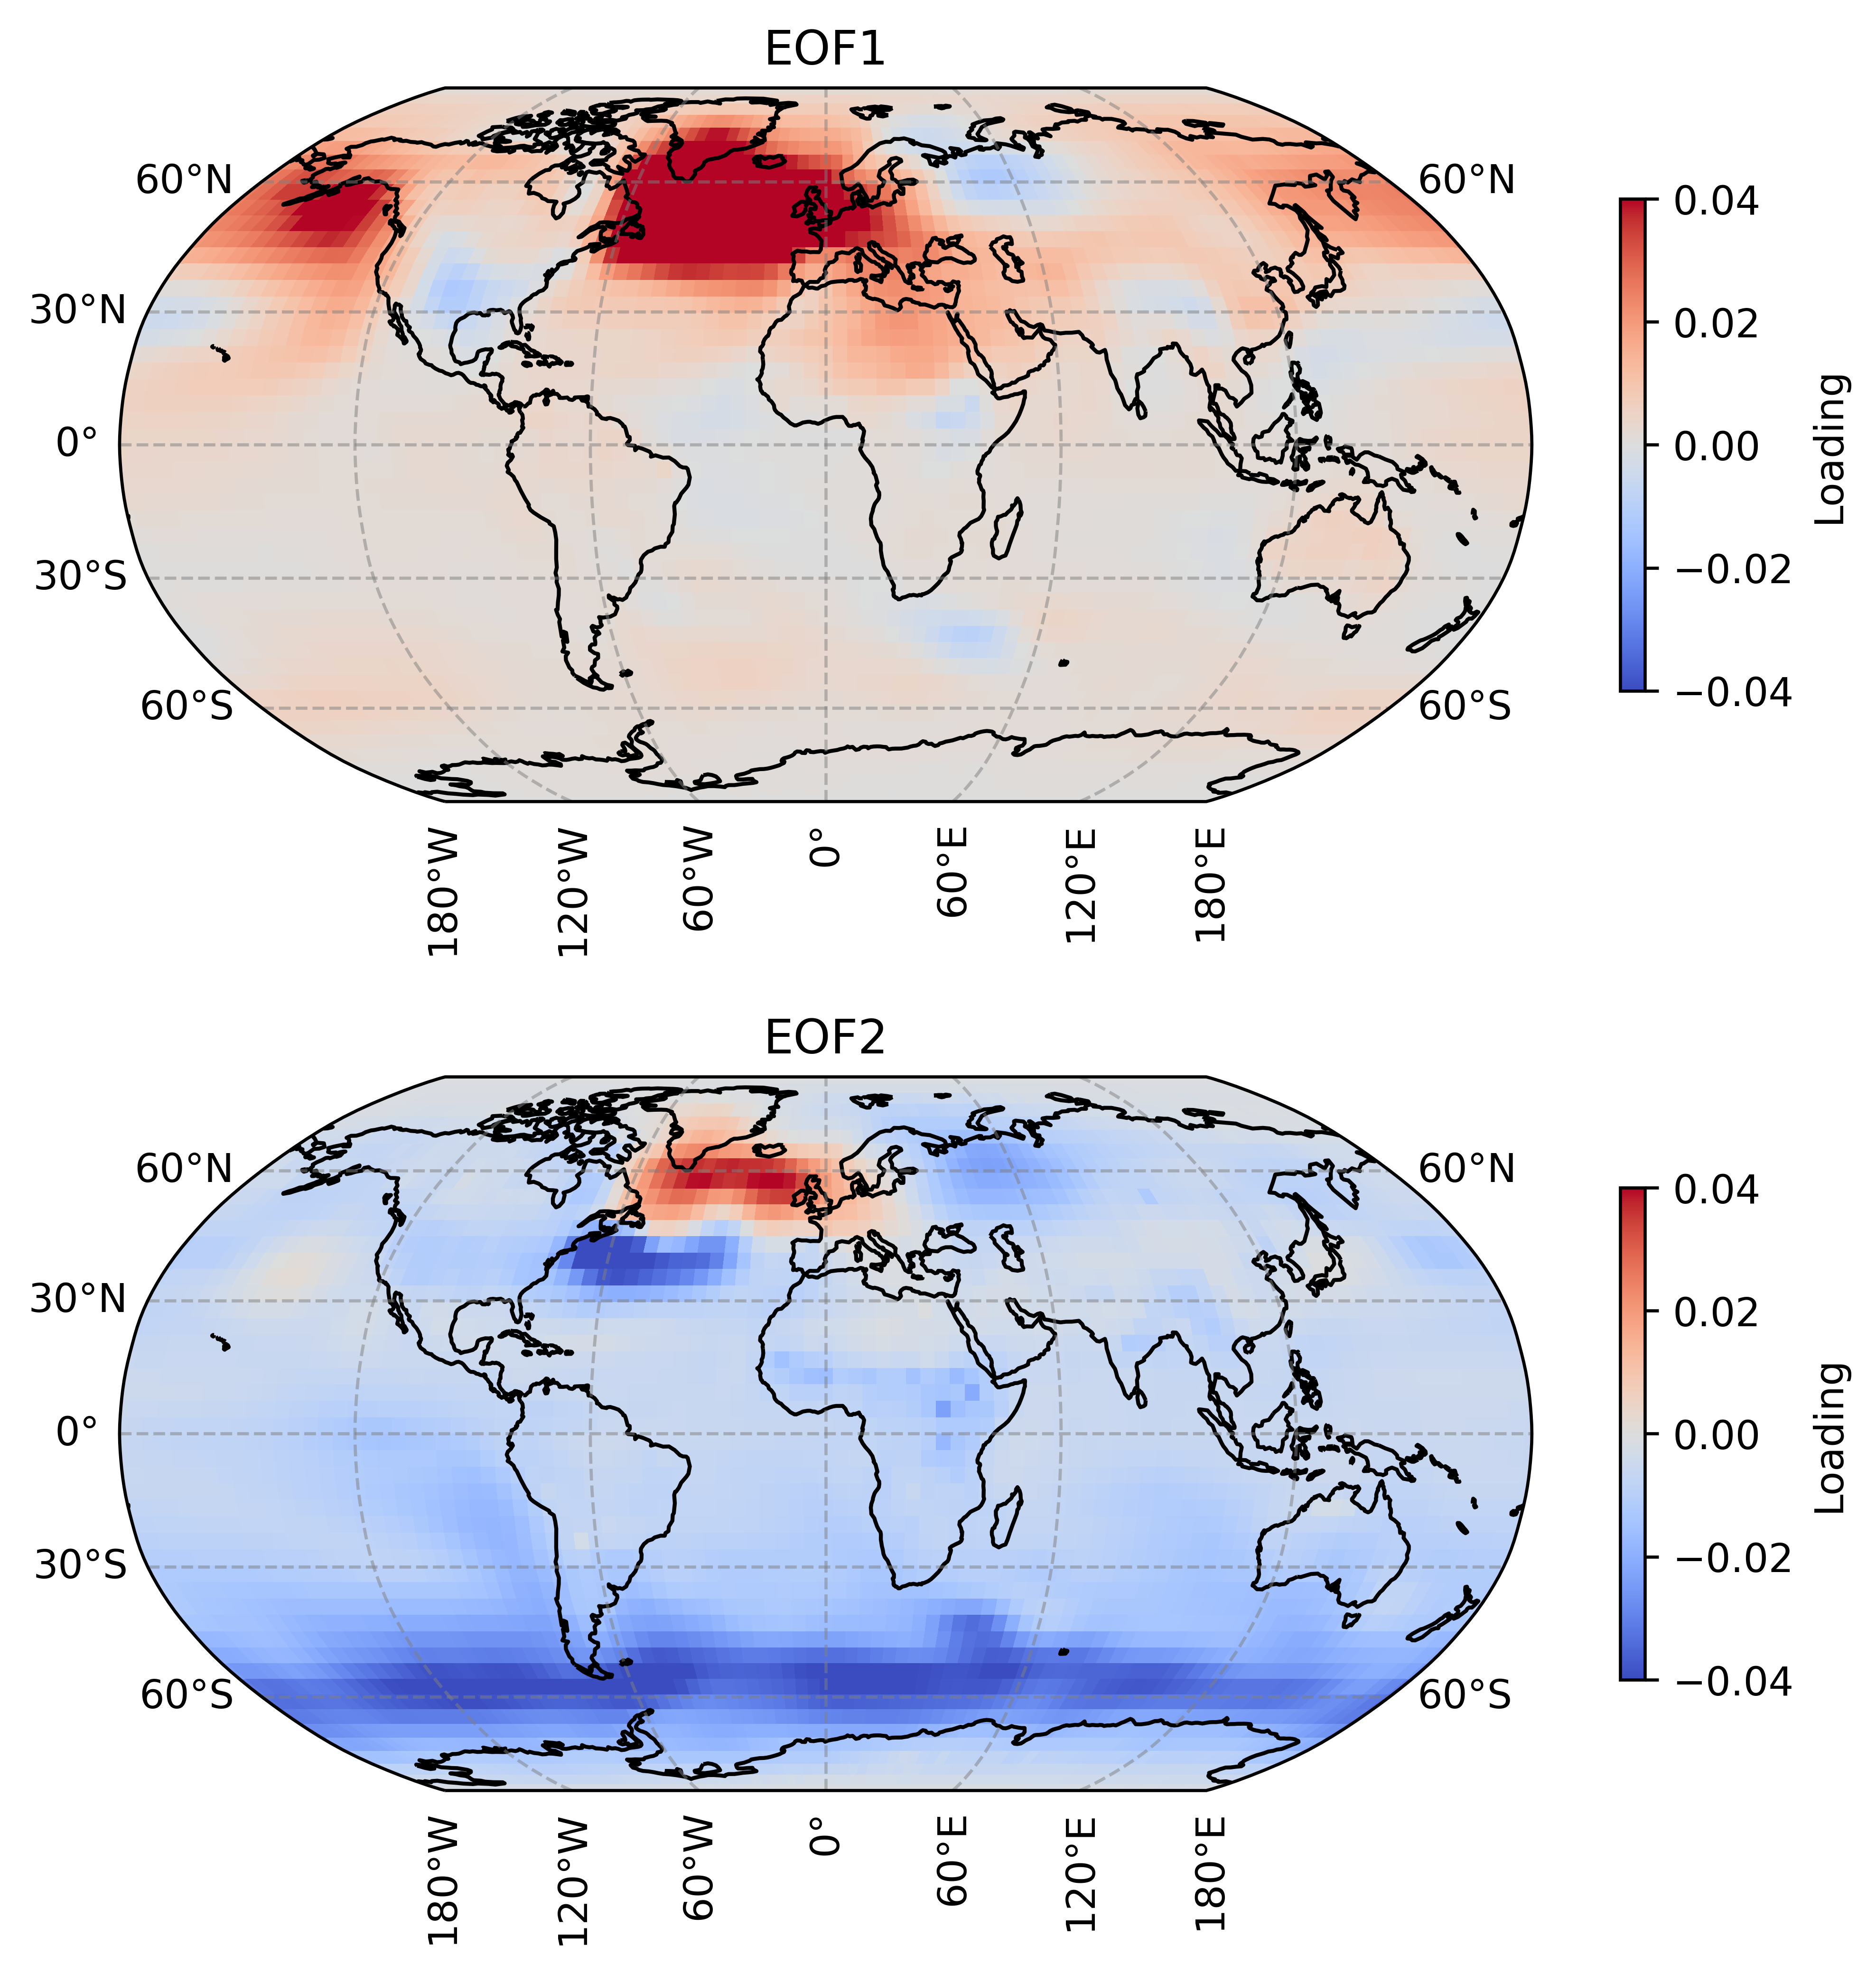

(<Figure size 4800x5400 with 4 Axes>,
 array([<GeoAxes: title={'center': 'EOF1'}>,
        <GeoAxes: title={'center': 'EOF2'}>], dtype=object))

In [8]:
# 5. Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs, exp_variance)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs, ds_sat['lat'].values, ds_sat['lon'].values)

# AIC

In [9]:
import xarray as xr
from sklearn.mixture import GaussianMixture
from toolbox import PCA_functions as pf

n_components_range = range(2, 9)  # 2 to 8 inclusive
aic_values = []

# Loop over the range of components
for n_components in n_components_range:
    # create a 2D GMM model
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')

    gmm.fit(eofs)

    aic_values.append(gmm.aic(eofs))


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluste

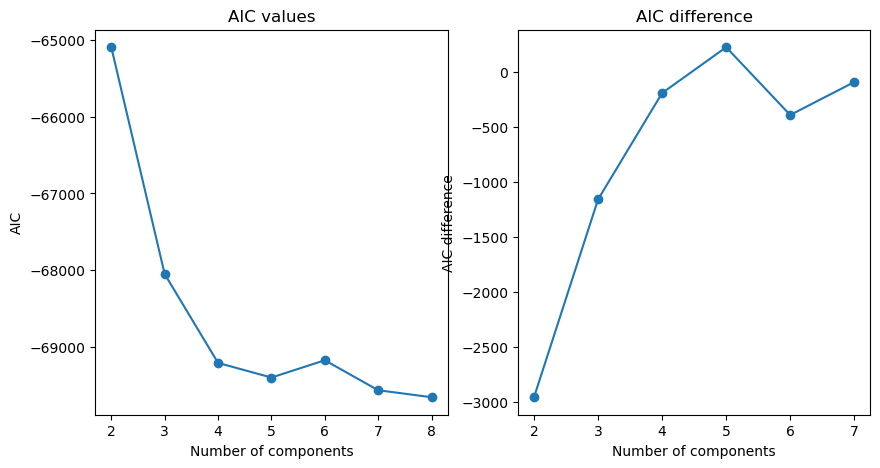

In [10]:
# plot the AIC values and delta AIC values (diff(AIC)) side by side 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_values, marker='o')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC values')

plt.subplot(1, 2, 2)
plt.plot(n_components_range[:-1], np.diff(aic_values), marker='o')
plt.xlabel('Number of components')
plt.ylabel('AIC difference')
plt.title('AIC difference')
plt.show()

# GMM

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


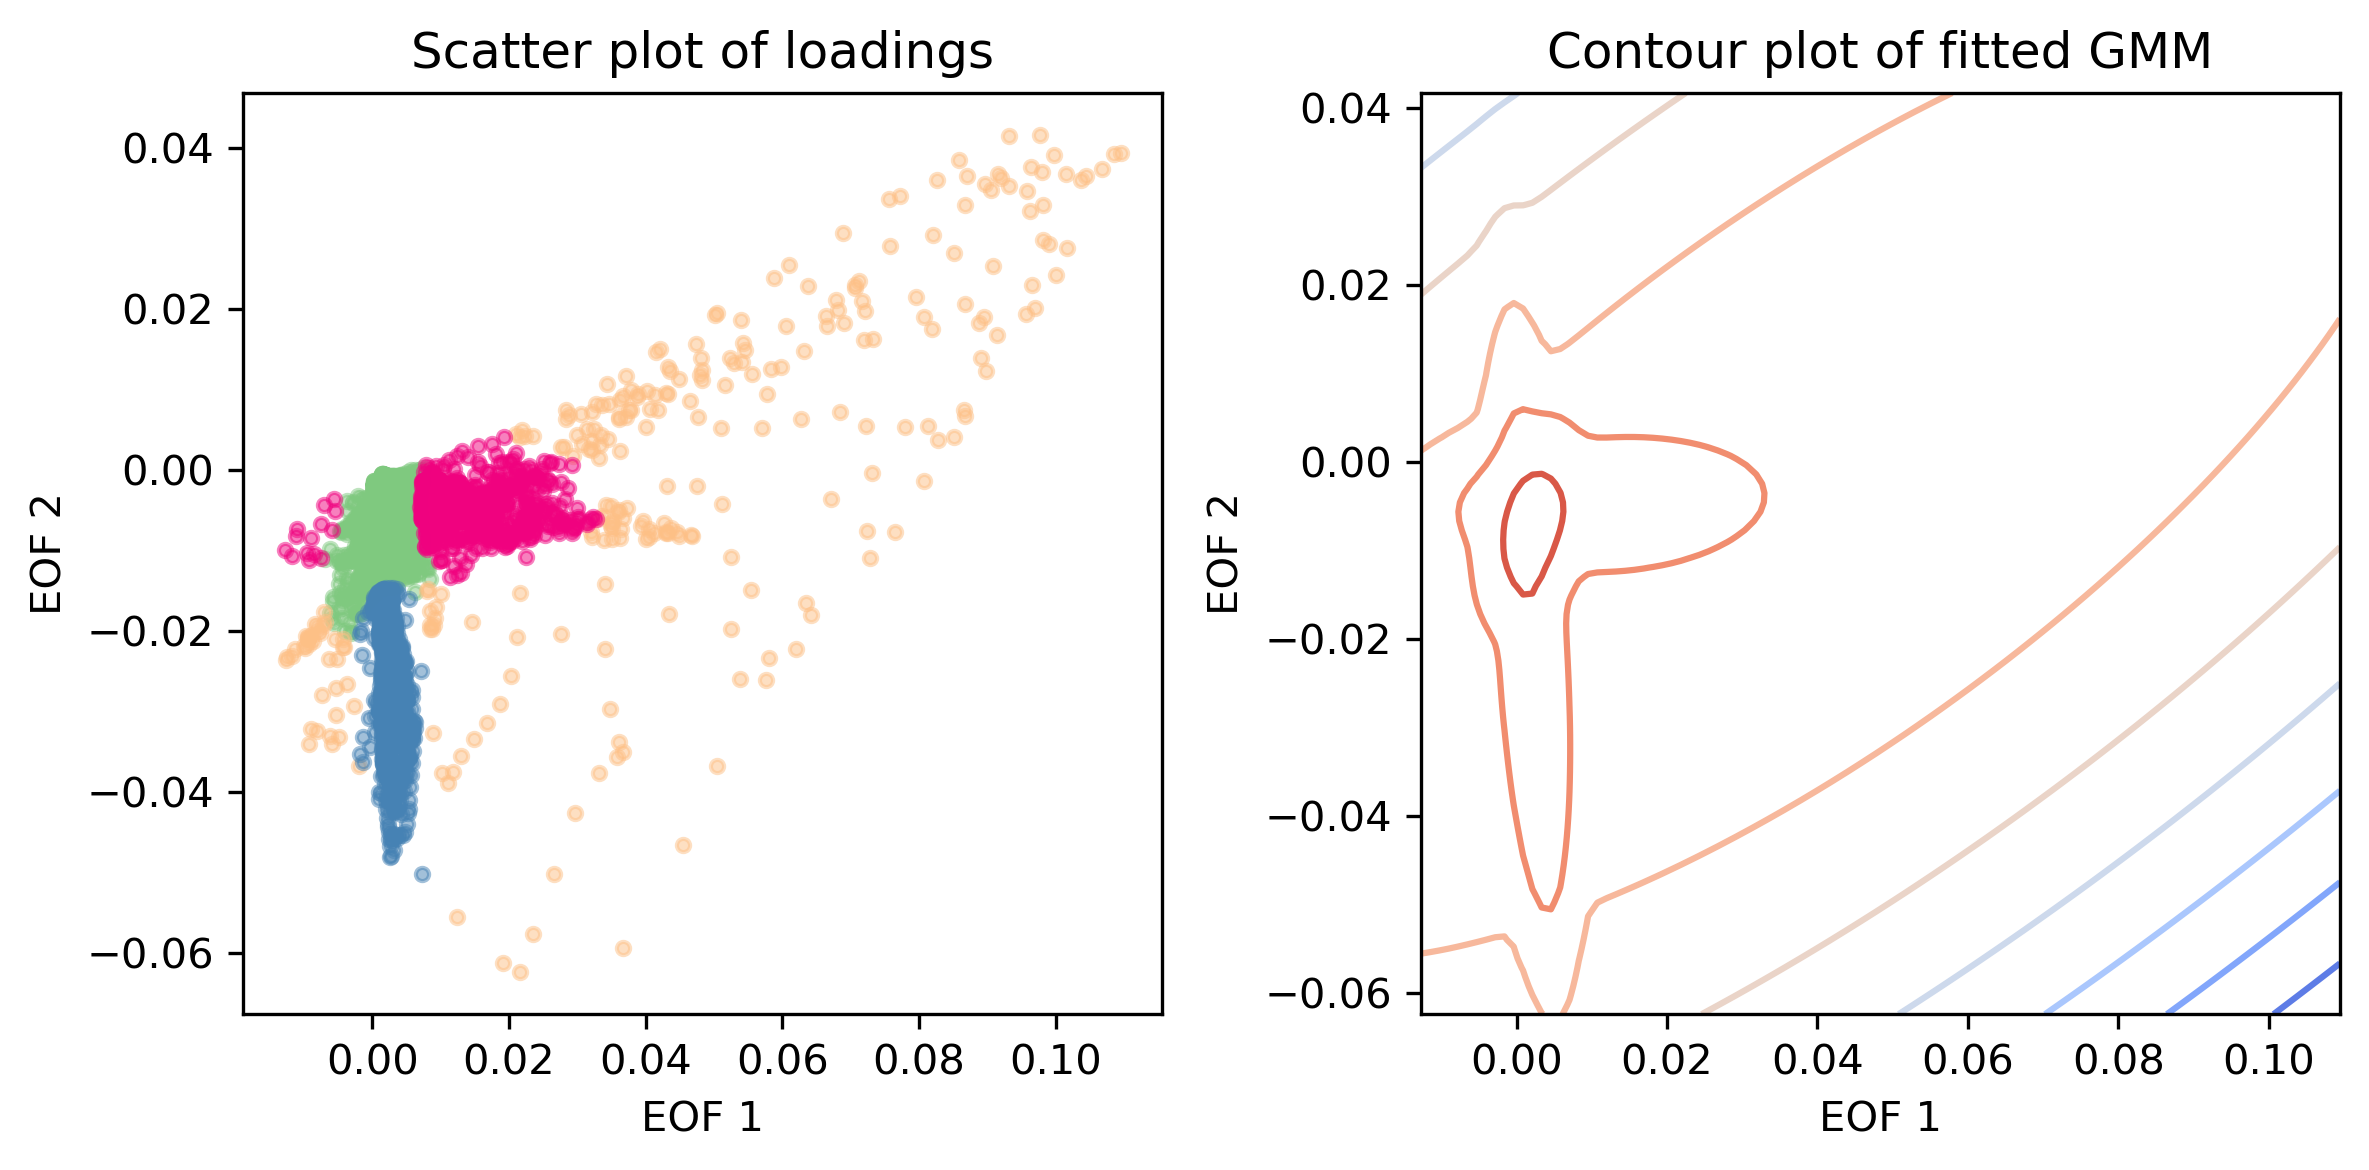

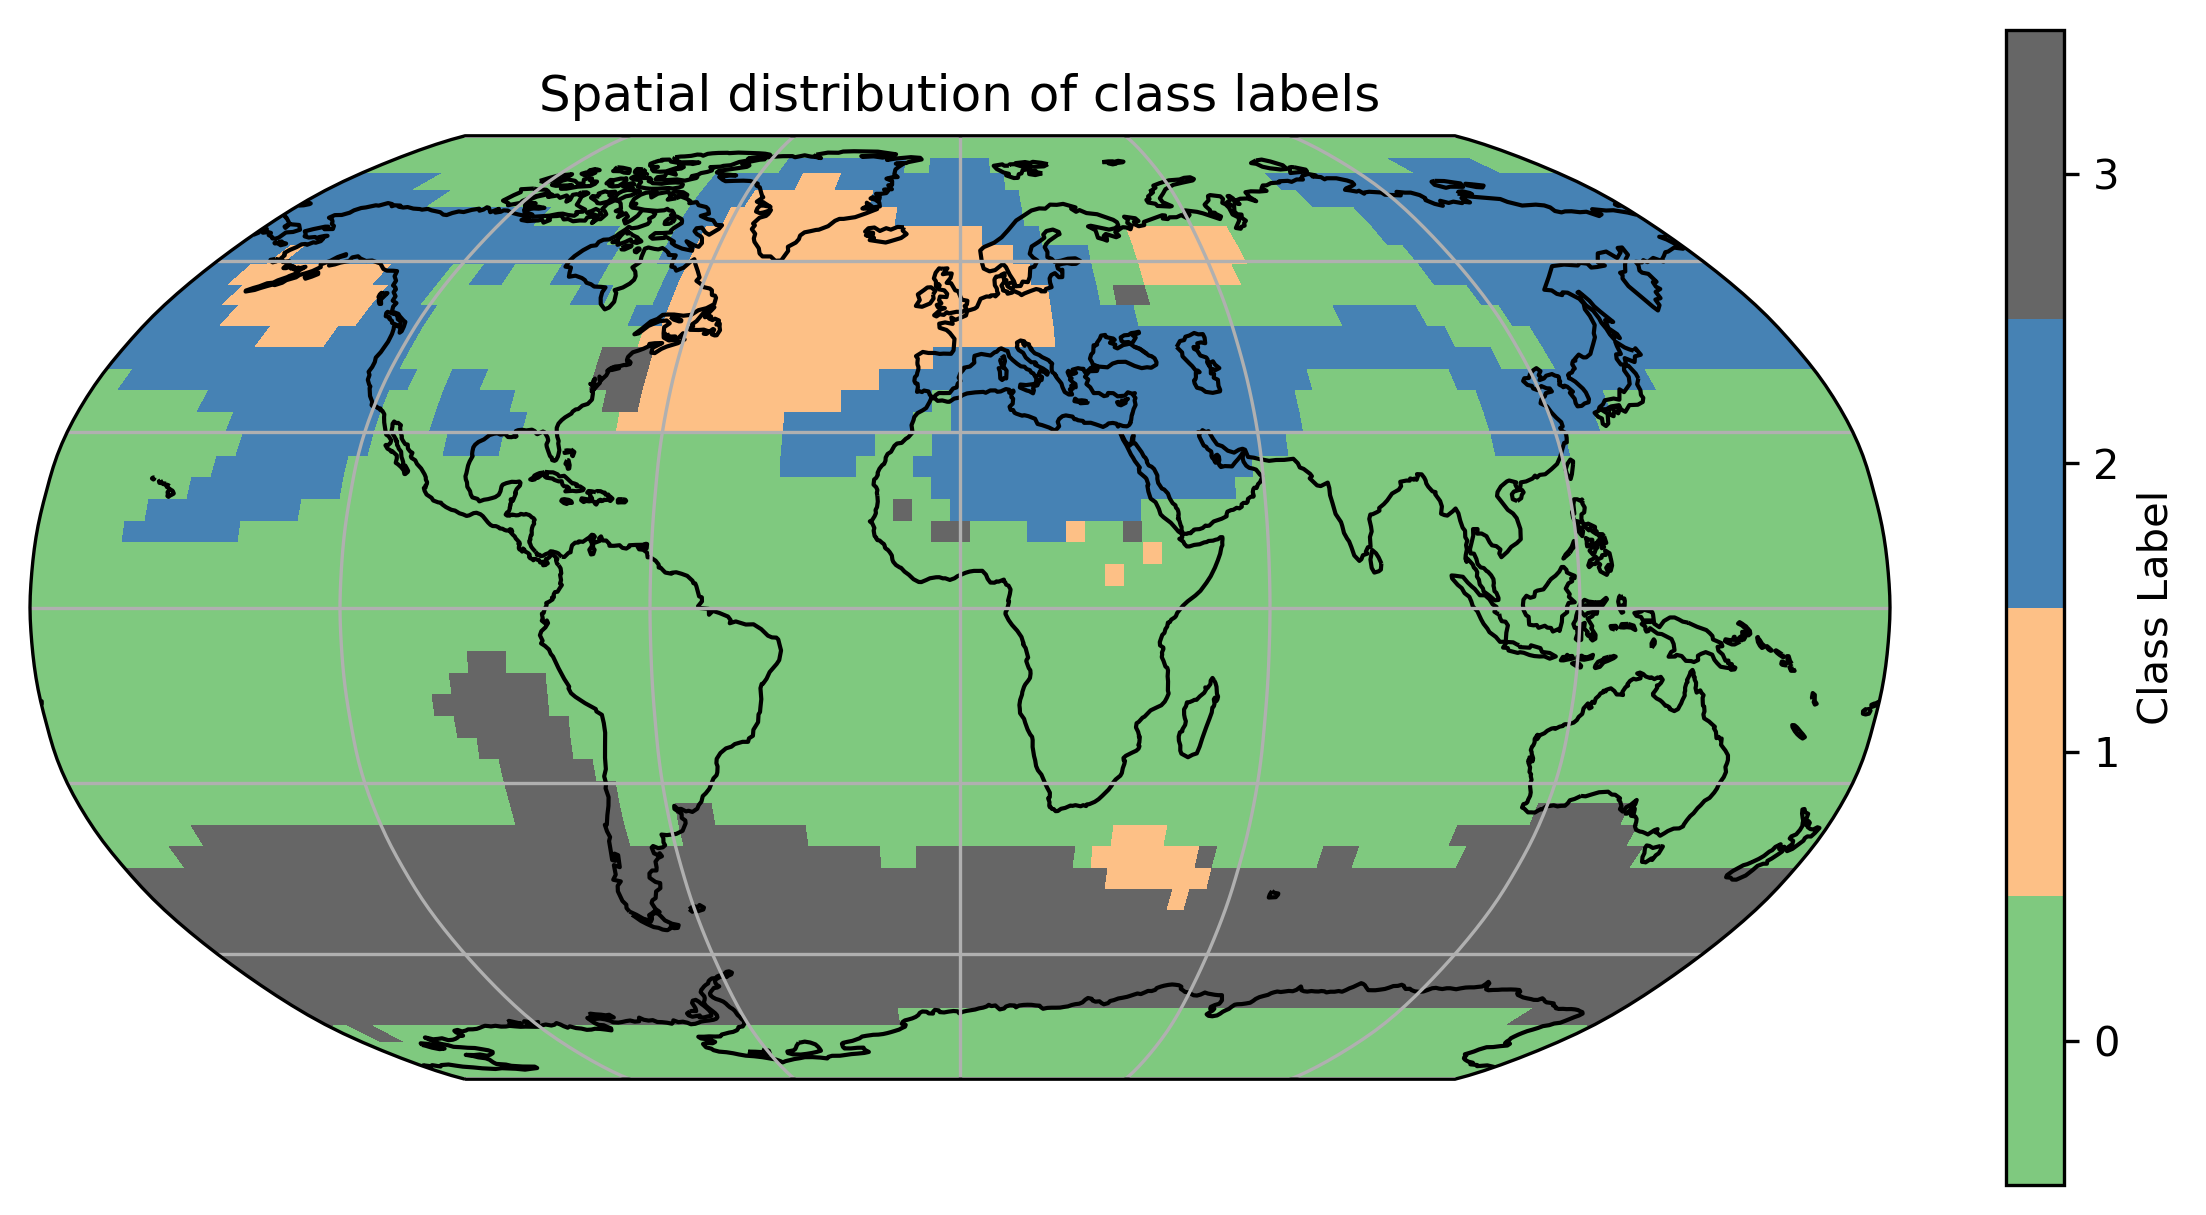

In [19]:
from toolbox import GMM_functions as gf
ds_EOFs_GMM,reshaped_probs=gf.GMM4EOFS(eofs, ds_sat,n_components=4)
gf.plot_labels(ds_EOFs_GMM)

In [16]:
# save ds_EOFs_GMM as a netcdf file named 'data/ds_sat_GMM.nc'
ds_EOFs_GMM.to_netcdf('data/ds_sat_GMM.nc')

# Plot the weighted average of classes

In [20]:
from toolbox import GMM_functions as gf
import importlib
importlib.reload(gf) 

weighted_avg_sat=gf.plot_weighted_average_curve(ds_EOFs_GMM.copy(), dpi=900)

In [14]:
# save the weighted_avg undere data/ using pickle

import pickle

with open('data/weighted_avg_sat.pkl', 'wb') as f:
    pickle.dump(weighted_avg_sat, f)
    

In [18]:
# load the weighted_avg from data/
import pickle

with open('data/weighted_avg_sat.pkl', 'rb') as f:
    weighted_avg_sat = pickle.load(f)

# PCMCI

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Class 0'>, <Axes: ylabel='Class 1'>,
        <Axes: ylabel='Class 2'>, <Axes: ylabel='Class 3'>], dtype=object))

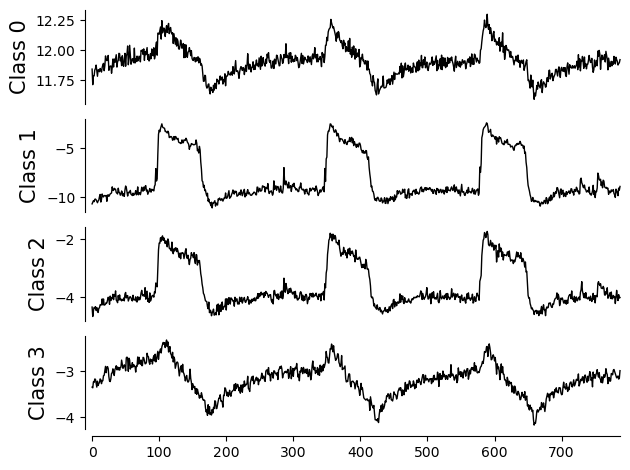

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = np.column_stack([weighted_avg_sat[key] for key in sorted(weighted_avg_sat.keys())])

# Create a Tigramite DataFrame object
var_names = [f"Class {k}" for k in sorted(weighted_avg_sat.keys())]
dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Class 0 has 3 link(s):
    [pc_alpha = 0.1]
        (Class 0 -2): max_pval = 0.00000, |min_val| =  0.183
        (Class 3 -1): max_pval = 0.00002, |min_val| =  0.153
        (Class 1 -1): max_pval = 0.00967, |min_val| =  0.092

    Variable Class 1 has 3 link(s):
    [pc_alpha = 0.4]
        (Class 1 -1): max_pval = 0.00000, |min_val| =  0.585
        (Class 2 -2): max_pval = 0.00008, |min_val| =  0.140
        (Class 3 -1): max_pval = 0.33118, |min_val| =  0.035

    Variable Class 2 has 6 link(s):
    [pc_alpha = 0.5]
        (Class 1 -1): max_pval = 0.00000, |min_val| =  0.454
        (Class 2 -2): max_pval = 0.00176, |min_val| =  0.112
        (Class 3 -1): max_pval = 0.25031, |min_val| =  0.041
        (Class 3 -2

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

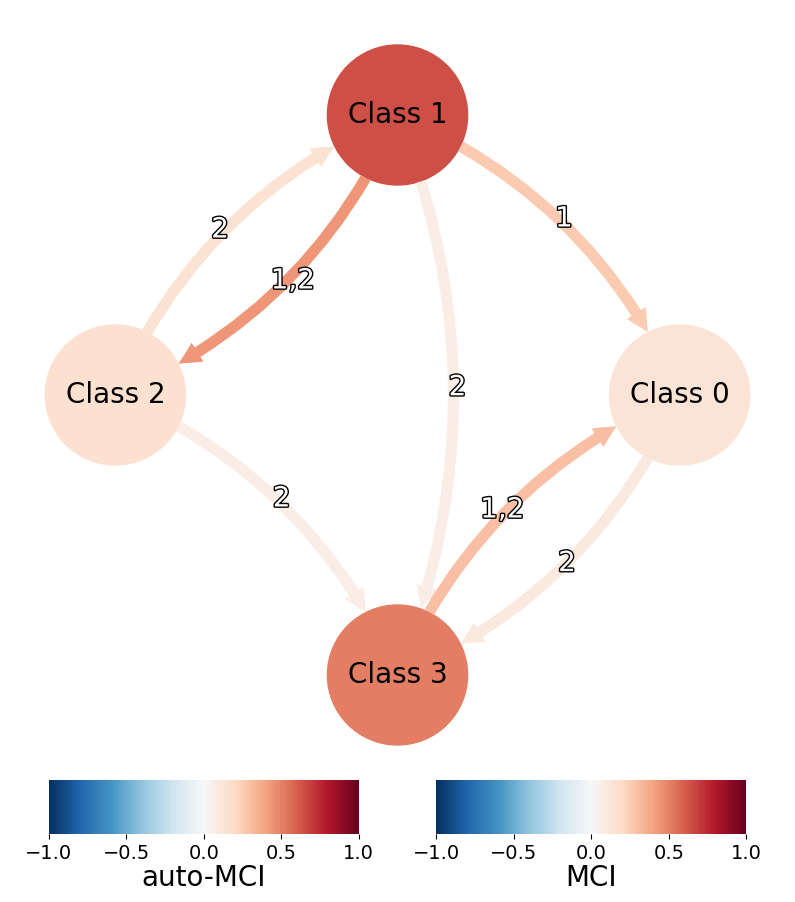

In [337]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=20,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
    )

In [332]:
import numpy as np

def print_significant_links(N, var_names, p_matrix, val_matrix, alpha_level=0.05):
    """Generates and returns significant links based on p-values and values matrices.

    Parameters
    ----------
    N : int
        The number of variables (typically, this is the shape of the first dimension of p_matrix and val_matrix).
    var_names : list of str
        Names of the variables corresponding to the dimensions of p_matrix and val_matrix.
    alpha_level : float, optional (default: 0.05)
        Significance level.
    p_matrix : array-like
        P-values matrix of shape (N, N, tau_max + 1).
    val_matrix : array-like
        Values matrix of shape (N, N, tau_max + 1).
    
    Returns
    -------
    str
        A string containing formatted significant links information.
    """
    sig_links = p_matrix <= alpha_level
    results_text = "\n## Significant links at alpha = %s:\n" % alpha_level

    for j in range(N):
        links = {(p[0], -p[1]): np.abs(val_matrix[p[0], j, abs(p[1])])
                 for p in zip(*np.where(sig_links[:, j, :]))}
        # Sort by value
        sorted_links = sorted(links, key=links.get, reverse=True)
        n_links = len(links)
        string = "    Variable %s has %d link(s):" % (var_names[j], n_links)
        for p in sorted_links:
            string += "\n        (%s % d): pval = %.5f" % (
                var_names[p[0]], p[1], p_matrix[p[0], j, abs(p[1])])
            string += " | val = % .3f" % (val_matrix[p[0], j, abs(p[1])])
        results_text += string + "\n"
        print(string)

    return results_text


# def parse_results_to_dict(results_text, var_names):
#     import re
#     causal_links = {}
#     # Split the text into lines and iterate over them
#     lines = results_text.split('\n')
    
#     current_var = None
#     for line in lines:
#         if "Variable" in line:
#             # Extract current variable index
#             match = re.search(r"Variable (.*?) has", line)
#             if match:
#                 current_var = var_names.index(match.group(1))
#                 causal_links[current_var] = []
#         elif "pval =" in line:
#             # Extract details of the link
#             cause_match = re.search(r"\((.*?)\)", line)
#             pval_match = re.search(r"pval = ([\d\.]+)", line)
#             val_match = re.search(r"val = ([\d\.\-]+)", line)
#             lag_match = re.search(r"(\-\d+)", cause_match.group(1))
#             cause_name = 'Class ' + cause_match.group(1).split(' ')[1]  # Ensure the correct format

#             if cause_match and pval_match and val_match and lag_match:
#                 cause_index = var_names.index(cause_name)
#                 link_detail = {
#                     "cause": cause_index,
#                     "lag": int(lag_match.group(1)),
#                     "pval": float(pval_match.group(1)),
#                     "val": float(val_match.group(1))
#                 }
#                 causal_links[current_var].append(link_detail)
    
#     return causal_links


# import re

# def parse_results_to_dict(results_text, var_names):
#     causal_links = {}
#     lines = results_text.split('\n')
    
#     current_var = None
#     for line in lines:
#         print(line+'end')
#         if "Variable" in line:
#             # Extract current variable index
#             match = re.search(r"Variable (.*?) has", line)
#             if match:
#                 current_var_name = match.group(1)
#                 current_var = var_names.index(current_var_name)
#                 causal_links[current_var] = []
#         elif "pval =" in line:
#             # Extract details of the link
#             cause_match = re.search(r"\((.*?)\)", line)
#             pval_match = re.search(r"pval = ([\d\.]+)", line)
#             val_match = re.search(r"\| val = ([\d\.\-]+)", line)

#             print(val_match)

#             lag_match = re.search(r"(\-\d+)", cause_match.group(1))
            
#             if cause_match and pval_match and val_match and lag_match:
#                 cause_name = 'Class ' + cause_match.group(1).split(' ')[1]  # Ensure the correct format
#                 cause_index = var_names.index(cause_name)
#                 link_detail = {
#                     "cause": cause_index,
#                     "lag": int(lag_match.group(1)),
#                     "pval": float(pval_match.group(1)),
#                     "val": float(val_match.group(1))  # Ensure correct float parsing
#                 }
#                 causal_links[current_var].append(link_detail)
    
#     return causal_links


import re

def parse_results_to_dict(results_text, var_names):
    causal_links = {}
    lines = results_text.split('\n')
    
    current_var = None
    for line in lines:
        print(repr(line))  # Use repr to show hidden characters like tabs or multiple spaces

        if "Variable" in line:
            match = re.search(r"Variable\s+(.*?)\s+has", line)  # More flexible with spaces
            if match:
                current_var_name = match.group(1)
                current_var = var_names.index(current_var_name)
                causal_links[current_var] = []

        elif "pval =" in line:
            cause_match = re.search(r"\((.*?)\)", line)
            pval_match = re.search(r"pval = ([\d\.]+)", line)
            # More robust regex, considering possible extra spaces and different formatting
            val_match = re.search(r"\|\s*val\s*=\s*([-\d\.]+)", line)

            print("Val match found:", val_match)

            lag_match = re.search(r"(\-\d+)", cause_match.group(1))
            
            if cause_match and pval_match and val_match and lag_match:
                cause_name = 'Class ' + cause_match.group(1).split(' ')[1]  # Ensure correct format
                cause_index = var_names.index(cause_name)
                link_detail = {
                    "cause": cause_index,
                    "lag": int(lag_match.group(1)),
                    "pval": float(pval_match.group(1)),
                    "val": float(val_match.group(1))
                }
                causal_links[current_var].append(link_detail)
    
    return causal_links


# def sort_causal_links_by_val(causal_links):
#     """Sorts each list of dictionaries in the causal_links dictionary by the absolute value of 'val'."""
#     sorted_causal_links = {}
#     for key, links in causal_links.items():
#         sorted_links = sorted(links, key=lambda x: abs(x['val']))
#         sorted_causal_links[key] = sorted_links
#     return sorted_causal_links

def sort_causal_links_by_val(causal_links, ascending=True):
    sorted_causal_links = {}
    for key, links in causal_links.items():
        sorted_links = sorted(links, key=lambda x: abs(x['val']), reverse=not ascending)
        sorted_causal_links[key] = sorted_links
    return sorted_causal_links





N = 4  # Number of variables
var_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Example variable names


results_text=print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = parse_results_to_dict(results_text, var_names)
causal_links

causal_links = sort_causal_links_by_val(causal_links)
causal_links

    Variable Class 0 has 4 link(s):
        (Class 3 -1): pval = 0.00000 | val =  0.301
        (Class 1 -1): pval = 0.00000 | val =  0.264
        (Class 0 -2): pval = 0.00012 | val =  0.137
        (Class 3 -2): pval = 0.00131 | val =  0.115
    Variable Class 1 has 3 link(s):
        (Class 1 -1): pval = 0.00000 | val =  0.641
        (Class 2 -2): pval = 0.00001 | val =  0.155
        (Class 1 -2): pval = 0.01657 | val =  0.086
    Variable Class 2 has 3 link(s):
        (Class 1 -1): pval = 0.00000 | val =  0.444
        (Class 2 -2): pval = 0.00001 | val =  0.162
        (Class 1 -2): pval = 0.03697 | val =  0.075
    Variable Class 3 has 5 link(s):
        (Class 3 -1): pval = 0.00000 | val =  0.515
        (Class 3 -2): pval = 0.00000 | val =  0.179
        (Class 0 -2): pval = 0.00718 | val =  0.096
        (Class 2 -2): pval = 0.04146 | val =  0.073
        (Class 1 -2): pval = 0.04623 | val =  0.071
''
'## Significant links at alpha = 0.05:'
'    Variable Class 0 has 4 link(

{0: [{'cause': 3, 'lag': -2, 'pval': 0.00131, 'val': 0.115},
  {'cause': 0, 'lag': -2, 'pval': 0.00012, 'val': 0.137},
  {'cause': 1, 'lag': -1, 'pval': 0.0, 'val': 0.264},
  {'cause': 3, 'lag': -1, 'pval': 0.0, 'val': 0.301}],
 1: [{'cause': 1, 'lag': -2, 'pval': 0.01657, 'val': 0.086},
  {'cause': 2, 'lag': -2, 'pval': 1e-05, 'val': 0.155},
  {'cause': 1, 'lag': -1, 'pval': 0.0, 'val': 0.641}],
 2: [{'cause': 1, 'lag': -2, 'pval': 0.03697, 'val': 0.075},
  {'cause': 2, 'lag': -2, 'pval': 1e-05, 'val': 0.162},
  {'cause': 1, 'lag': -1, 'pval': 0.0, 'val': 0.444}],
 3: [{'cause': 1, 'lag': -2, 'pval': 0.04623, 'val': 0.071},
  {'cause': 2, 'lag': -2, 'pval': 0.04146, 'val': 0.073},
  {'cause': 0, 'lag': -2, 'pval': 0.00718, 'val': 0.096},
  {'cause': 3, 'lag': -2, 'pval': 0.0, 'val': 0.179},
  {'cause': 3, 'lag': -1, 'pval': 0.0, 'val': 0.515}]}

In [333]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.cm as cm
from matplotlib.patches import ConnectionPatch

def plot_class_center_with_causal(ds, label_var_name='class_label', dpi=100, title_text='', node_size=15, causal_links={}):
    sat_label = ds[label_var_name]
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k')

    unique_labels = np.unique(sat_label.values)

    # Select contrasting colors that will stand out against RdBu_r
    # custom_colors = [
    #     (0.6, 0.4, 0.8),  # purple
    #     (0.0, 0.6, 0.5),  # teal
    #     (0.9, 0.6, 0.0),  # orange
    #     (0.3, 0.7, 0.9),  # sky blue
    #     (0.7, 0.8, 0.4),  # olive green
    #     (0.8, 0.4, 0.4),  # pale red (ok with RdBu_r if needed)
    #     (0.6, 0.8, 0.2),  # lime green
    #     (0.5, 0.3, 0.7),  # indigo
    # ]
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
        (0.7, 0.85, 0.9),  # pale cyan
        (0.65, 0.2, 0.2),  # burgundy, avoid if too close to red
        (0.8, 0.7, 0.15),  # mustard
    ]
    cmap = ListedColormap(custom_colors[:len(unique_labels)])  # Use only as many colors as needed

    lon_adjusted = (ds['lon'].values + 180) % 360 - 180
    lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)

    # Plot the labels
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False, alpha=1)
    ax.set_global()
    ax.set_title(title_text)

    # Compute centroids and plot them
    centroids = {}
    for label in unique_labels:
        mask = sat_label.values == label
        lon_mean = np.median(lon[mask])
        lat_mean = np.median(lat[mask])
        centroids[label] = (lon_mean, lat_mean)
        ax.plot(lon_mean, lat_mean, 'ko', markersize=node_size, markeredgecolor='white')
        # Add label near each centroid
        ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)

    # Setup the color bar for labels
    bounds = np.arange(len(unique_labels) + 1) - 0.5
    ticks = np.arange(len(unique_labels))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks, shrink=0.7)
    cbar.ax.set_yticklabels(unique_labels)
    cbar.ax.set_ylabel('Class Labels')

    # Plot causal links with curved arrows
    val_norm = Normalize(vmin=-1, vmax=1)  # Adjusted for arrow color range
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        for link in links:
            cause = link['cause']
            val = link['val']
            print(cause, target, val)
            if cause in centroids and target in centroids:
                arrow = ConnectionPatch(xyA=centroids[cause], xyB=centroids[target], coordsA='data', coordsB='data',
                                        arrowstyle="-|>", color=cmap_arrow(val_norm(val)), lw=3, shrinkA=8, shrinkB=8, 
                                        connectionstyle="arc3,rad=0.3")
                ax.add_patch(arrow)

    # Add a color bar for the arrows
    sm = cm.ScalarMappable(cmap=cmap_arrow, norm=val_norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, 0.1, 0.56, 0.03])  # Position for bottom colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Causal Strength')

    plt.show()
    return centroids



3 0 0.115
0 0 0.137
1 0 0.264
3 0 0.301
1 1 0.086
2 1 0.155
1 1 0.641
1 2 0.075
2 2 0.162
1 2 0.444
1 3 0.071
2 3 0.073
0 3 0.096
3 3 0.179
3 3 0.515


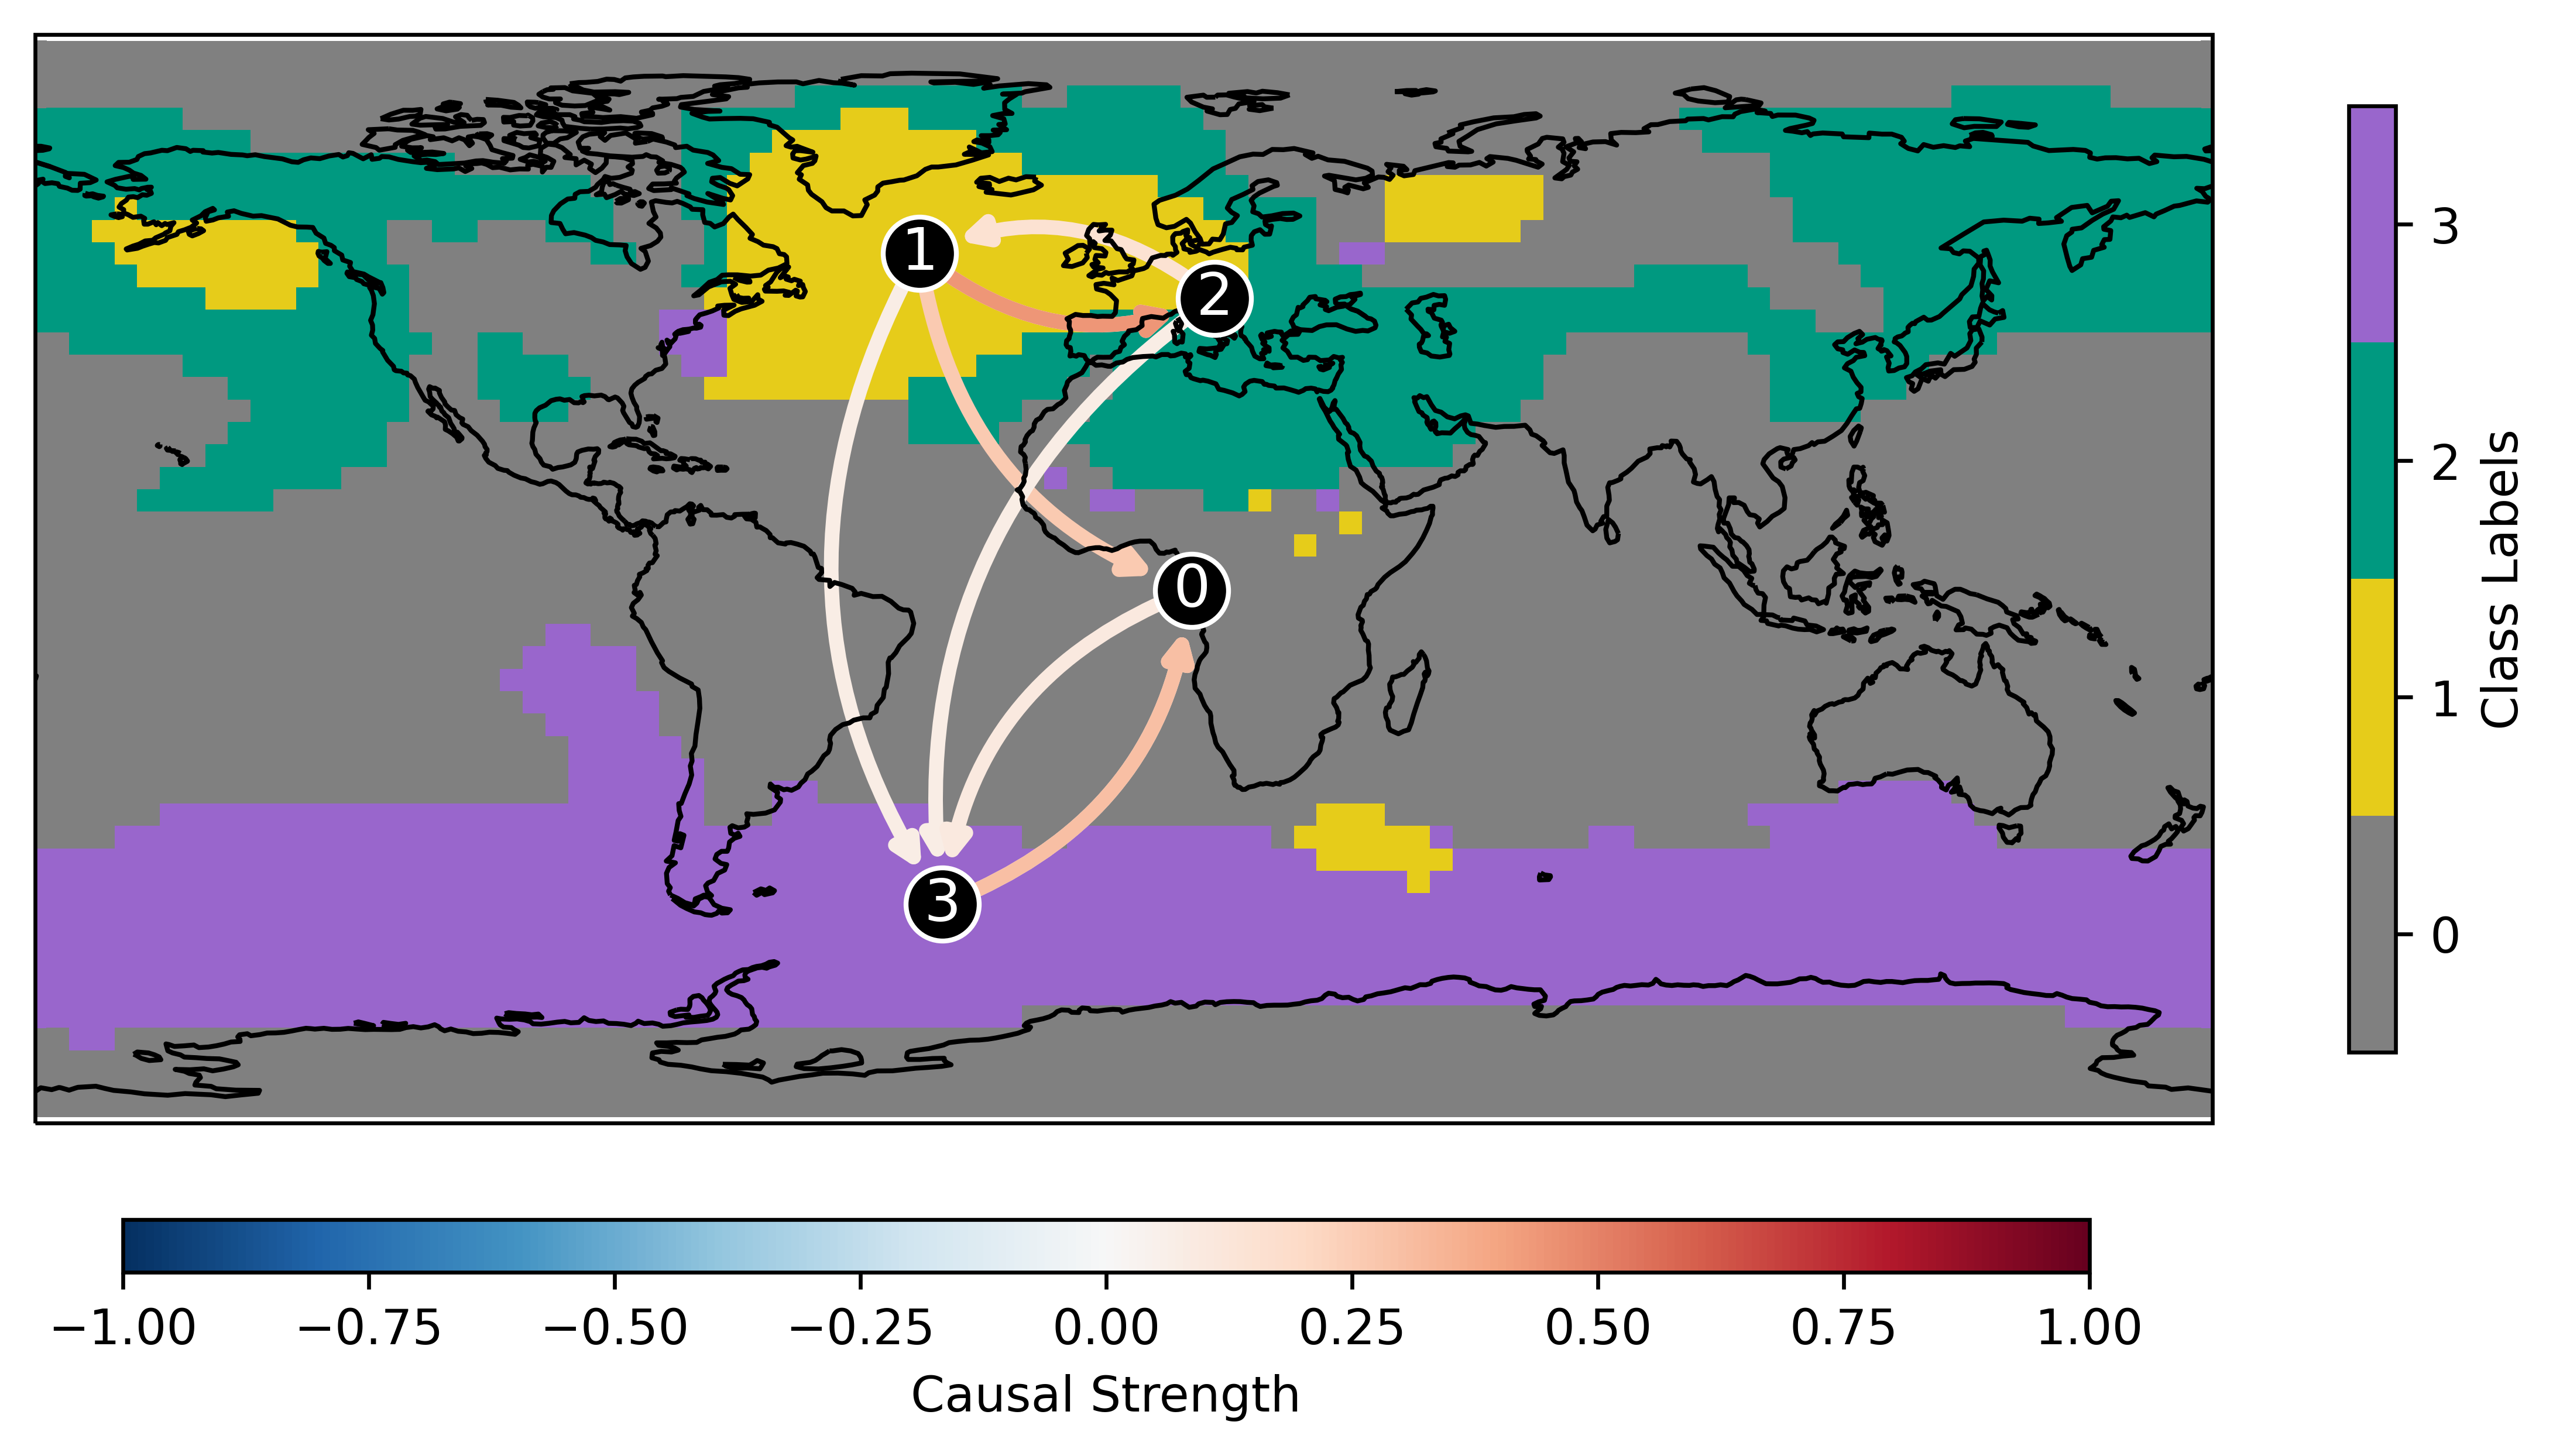

In [335]:
centroids = plot_class_center_with_causal(ds_EOFs_GMM, label_var_name='class_label', dpi=600, title_text='', node_size=15, causal_links=causal_links)
    

In [233]:
import numpy as np

def print_significant_links(N, var_names, p_matrix, val_matrix, alpha_level=0.05):
    """Prints significant links based on p-values and values matrices.

    Parameters
    ----------
    N : int
        The number of variables (typically, this is the shape of the first dimension of p_matrix and val_matrix).
    var_names : list of str
        Names of the variables corresponding to the dimensions of p_matrix and val_matrix.
    alpha_level : float, optional (default: 0.05)
        Significance level.
    p_matrix : array-like
        P-values matrix of shape (N, N, tau_max + 1).
    val_matrix : array-like
        Values matrix of shape (N, N, tau_max + 1).
    """
    sig_links = p_matrix <= alpha_level
    print("\n## Significant links at alpha = %s:" % alpha_level)

    for j in range(N):
        links = {(p[0], -p[1]): np.abs(val_matrix[p[0], j, abs(p[1])])
                 for p in zip(*np.where(sig_links[:, j, :]))}
        # Sort by value
        sorted_links = sorted(links, key=links.get, reverse=True)
        n_links = len(links)
        string = ("\n    Variable %s has %d link(s):" % (var_names[j], n_links))
        for p in sorted_links:
            string += ("\n        (%s % d): pval = %.5f" %
                       (var_names[p[0]], p[1], p_matrix[p[0], j, abs(p[1])]))
            string += " | val = % .3f" % (val_matrix[p[0], j, abs(p[1])])
        print(string)

# Example usage
N = 4  # Number of variables
var_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Example variable names


print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)



## Significant links at alpha = 0.05:

    Variable Class 0 has 4 link(s):
        (Class 3 -1): pval = 0.00000 | val =  0.301
        (Class 1 -1): pval = 0.00000 | val =  0.264
        (Class 0 -2): pval = 0.00012 | val =  0.137
        (Class 3 -2): pval = 0.00131 | val =  0.115

    Variable Class 1 has 3 link(s):
        (Class 1 -1): pval = 0.00000 | val =  0.641
        (Class 2 -2): pval = 0.00001 | val =  0.155
        (Class 1 -2): pval = 0.01657 | val =  0.086

    Variable Class 2 has 3 link(s):
        (Class 1 -1): pval = 0.00000 | val =  0.444
        (Class 2 -2): pval = 0.00001 | val =  0.162
        (Class 1 -2): pval = 0.03697 | val =  0.075

    Variable Class 3 has 5 link(s):
        (Class 3 -1): pval = 0.00000 | val =  0.515
        (Class 3 -2): pval = 0.00000 | val =  0.179
        (Class 0 -2): pval = 0.00718 | val =  0.096
        (Class 2 -2): pval = 0.04146 | val =  0.073
        (Class 1 -2): pval = 0.04623 | val =  0.071


In [80]:
causal_links = {
    0: [
        {"cause": 3, "lag": -1, "pval": 0.00000, "val": 0.301},
        {"cause": 1, "lag": -1, "pval": 0.00000, "val": 0.264},
        {"cause": 0, "lag": -2, "pval": 0.00012, "val": 0.137},
        {"cause": 3, "lag": -2, "pval": 0.00131, "val": 0.115}
    ],
    1: [
        {"cause": 1, "lag": -1, "pval": 0.00000, "val": 0.641},
        {"cause": 2, "lag": -2, "pval": 0.00001, "val": 0.155},
        {"cause": 1, "lag": -2, "pval": 0.01657, "val": 0.086}
    ],
    2: [
        {"cause": 1, "lag": -1, "pval": 0.00000, "val": 0.444},
        {"cause": 2, "lag": -2, "pval": 0.00001, "val": 0.162},
        {"cause": 1, "lag": -2, "pval": 0.03697, "val": 0.075}
    ],
    3: [
        {"cause": 3, "lag": -1, "pval": 0.00000, "val": 0.515},
        {"cause": 3, "lag": -2, "pval": 0.00000, "val": 0.179},
        {"cause": 0, "lag": -2, "pval": 0.00718, "val": 0.096},
        {"cause": 2, "lag": -2, "pval": 0.04146, "val": 0.073},
        {"cause": 1, "lag": -2, "pval": 0.04623, "val": 0.071}
    ]
}


In [71]:
causal_links.items()

dict_items([(0, [{'target': 3, 'lag': -1, 'pval': 0.0, 'val': 0.301}, {'target': 1, 'lag': -1, 'pval': 0.0, 'val': 0.264}, {'target': 0, 'lag': -2, 'pval': 0.00012, 'val': 0.137}, {'target': 3, 'lag': -2, 'pval': 0.00131, 'val': 0.115}]), (1, [{'target': 1, 'lag': -1, 'pval': 0.0, 'val': 0.641}, {'target': 2, 'lag': -2, 'pval': 1e-05, 'val': 0.155}, {'target': 1, 'lag': -2, 'pval': 0.01657, 'val': 0.086}]), (2, [{'target': 1, 'lag': -1, 'pval': 0.0, 'val': 0.444}, {'target': 2, 'lag': -2, 'pval': 1e-05, 'val': 0.162}, {'target': 1, 'lag': -2, 'pval': 0.03697, 'val': 0.075}]), (3, [{'target': 3, 'lag': -1, 'pval': 0.0, 'val': 0.515}, {'target': 3, 'lag': -2, 'pval': 0.0, 'val': 0.179}, {'target': 0, 'lag': -2, 'pval': 0.00718, 'val': 0.096}, {'target': 2, 'lag': -2, 'pval': 0.04146, 'val': 0.073}, {'target': 1, 'lag': -2, 'pval': 0.04623, 'val': 0.071}])])

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

def plot_class_center(ds, label_var_name='class_label', dpi=100, title_text='', markersize=5, causal_links={}):
    sat_label = ds[label_var_name]
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)
    ax.add_feature(cfeature.COASTLINE)

    unique_labels = np.unique(sat_label.values)

    # Color map setup based on number of unique labels
    if len(unique_labels) <= 5:
        custom_colors = [
            (0.498, 0.788, 0.498),
            (0.992, 0.753, 0.526),
            (0.941, 0.008, 0.498),
            (0.275, 0.510, 0.706),
            (0.4, 0.4, 0.4),
        ]
        cmap = ListedColormap(custom_colors)
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))

    lon_adjusted=(ds['lon'].values + 180) % 360 - 180
    # Create 2D arrays for longitude and latitude
    lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)

    # Plot the labels
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False)
    ax.set_global()
    ax.set_title(title_text)

    # Compute centroids and plot them
    centroids = {}
    for label in unique_labels:
        mask = sat_label.values == label
        lon_mean = np.median(lon[mask])
        lat_mean = np.median(lat[mask])
        centroids[label] = (lon_mean, lat_mean)
        # print(f'Centroid for label {label}: {lon_mean}, {lat_mean}')
        ax.plot(lon_mean, lat_mean, 'ko', markersize=markersize, markeredgecolor='white')

    # Setup the color bar
    bounds = np.arange(len(unique_labels) + 1) - 0.5
    ticks = np.arange(len(unique_labels))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(unique_labels)
    cbar.ax.set_ylabel('')
    plt.show()

    return centroids


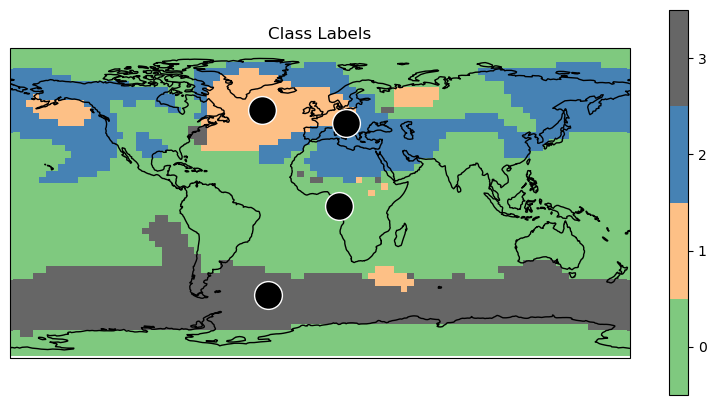

{0: (11.25, -1.8555714859932573),
 1: (-33.75, 53.810274031941425),
 2: (15.0, 46.38855811160543),
 3: (-30.0, -53.810274031941425)}

In [128]:
centroids=plot_class_center(ds_EOFs_GMM, label_var_name='class_label', dpi=100, title_text='Class Labels', markersize=20, causal_links=causal_links)
centroids

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.cm as cm
from matplotlib.patches import ConnectionPatch

def plot_class_center_with_causal(ds, label_var_name='class_label', dpi=100, title_text='', node_size=15, causal_links={}):
    sat_label = ds[label_var_name]
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)
    ax.add_feature(cfeature.COASTLINE)

    unique_labels = np.unique(sat_label.values)

    # Color map setup based on number of unique labels
    if len(unique_labels) <= 5:
        custom_colors = [
            (0.498, 0.788, 0.498),
            (0.992, 0.753, 0.526),
            (0.941, 0.008, 0.498),
            (0.275, 0.510, 0.706),
            (0.4, 0.4, 0.4),
        ]
        cmap = ListedColormap(custom_colors)
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))

    lon_adjusted = (ds['lon'].values + 180) % 360 - 180
    lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)

    # Plot the labels
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False, alpha=1)
    ax.set_global()
    ax.set_title(title_text)

    # Compute centroids and plot them
    centroids = {}
    for label in unique_labels:
        mask = sat_label.values == label
        lon_mean = np.median(lon[mask])
        lat_mean = np.median(lat[mask])
        centroids[label] = (lon_mean, lat_mean)
        ax.plot(lon_mean, lat_mean, 'ko', markersize=node_size, markeredgecolor='white')

    # Setup the color bar for labels
    bounds = np.arange(len(unique_labels) + 1) - 0.5
    ticks = np.arange(len(unique_labels))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks, shrink=0.7)
    cbar.ax.set_yticklabels(unique_labels)
    cbar.ax.set_ylabel('Class Labels')

    # Plot causal links with curved arrows
    val_norm = Normalize(vmin=-1, vmax=1)  # Adjusted for arrow color range
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        for link in links:
            cause = link['cause']
            val = link['val']
            if cause in centroids and target in centroids:
                arrow = ConnectionPatch(xyA=centroids[cause], xyB=centroids[target], coordsA='data', coordsB='data',
                                        arrowstyle="-|>", color=cmap_arrow(val_norm(val)), lw=2, shrinkA=8, shrinkB=8, 
                                        connectionstyle="arc3,rad=0.3")
                ax.add_patch(arrow)

    # Add a color bar for the arrows
    sm = cm.ScalarMappable(cmap=cmap_arrow, norm=val_norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, 0.1, 0.56, 0.03])  # Position for bottom colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Causal Strength')

    plt.show()
    return centroids


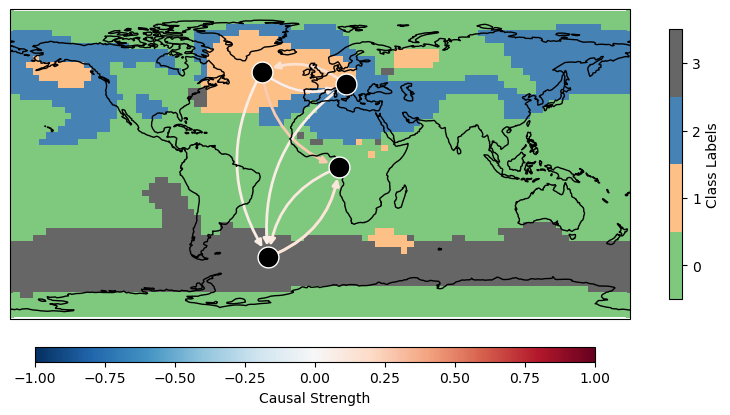

{0: (11.25, -1.8555714859932573),
 1: (-33.75, 53.810274031941425),
 2: (15.0, 46.38855811160543),
 3: (-30.0, -53.810274031941425)}

In [212]:
centroids=plot_class_center_with_causal(ds_EOFs_GMM, label_var_name='class_label', dpi=100, title_text='', node_size=15, causal_links=causal_links)
centroids

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_class_center_with_causal(ds, label_var_name='class_label', dpi=100, title_text='', causal_links={}):
    sat_label = ds[label_var_name]
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)
    ax.add_feature(cfeature.COASTLINE)

    unique_labels = np.unique(sat_label.values)

    # Color map setup based on number of unique labels
    if len(unique_labels) <= 5:
        custom_colors = [
            (0.498, 0.788, 0.498),
            (0.992, 0.753, 0.526),
            (0.941, 0.008, 0.498),
            (0.275, 0.510, 0.706),
            (0.4, 0.4, 0.4),
        ]
        cmap = ListedColormap(custom_colors)
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))

    lon_adjusted = (ds['lon'].values + 180) % 360 - 180
    lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)

    # Plot the labels
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False)
    ax.set_global()
    ax.set_title(title_text)

    # Compute centroids and plot them
    centroids = {}
    for label in unique_labels:
        mask = sat_label.values == label
        lon_mean = np.median(lon[mask])
        lat_mean = np.median(lat[mask])
        centroids[label] = (lon_mean, lat_mean)
        ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')

    # Setup the color bar for labels
    bounds = np.arange(len(unique_labels) + 1) - 0.5
    ticks = np.arange(len(unique_labels))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(unique_labels)
    cbar.ax.set_ylabel('')

    # Plot causal links with arrows
    val_norm = Normalize(vmin=0, vmax=max([link['val'] for sublist in causal_links.values() for link in sublist]))
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        for link in links:
            cause = link['cause']
            val = link['val']
            if cause in centroids and target in centroids:
                # ax.annotate('', xy=centroids[target], xytext=centroids[cause],
                #             arrowprops=dict(facecolor=cmap_arrow(val_norm(val)), edgecolor='none', 
                #                             arrowstyle='->', linewidth=2, alpha=0.6))
                ax.annotate('', xy=centroids[target], xycoords='data',
                xytext=centroids[cause], textcoords='data',
                arrowprops=dict(arrowstyle="->", color=cmap_arrow(val_norm(val)), lw=2, shrinkA=5, shrinkB=5))

    plt.show()
    return centroids


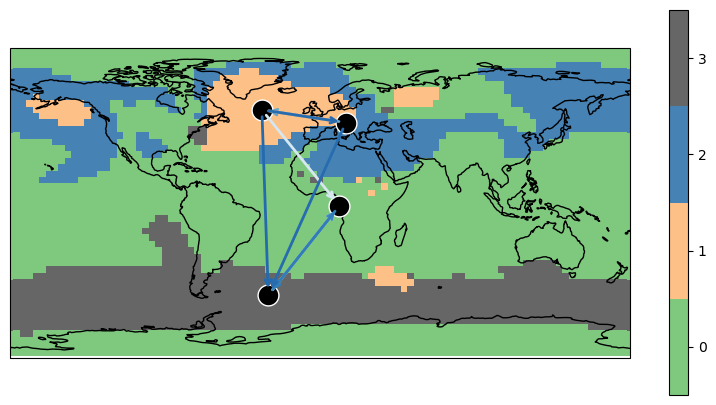

{0: (11.25, -1.8555714859932573),
 1: (-33.75, 53.810274031941425),
 2: (15.0, 46.38855811160543),
 3: (-30.0, -53.810274031941425)}

In [150]:
centroids=plot_class_center_with_causal(ds_EOFs_GMM, label_var_name='class_label', dpi=100, title_text='', causal_links=causal_links)
centroids

In [103]:
ds_EOFs_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 -60.7 -60.9 ... -45.53 -45.45
    TREFHT_centered        (age, lat, lon) float32 0.08495 0.09824 ... -0.7201
    weight                 (lat) float64 0.04956 0.1136 ... 0.1136 0.04956
    TREFHT_c_w             (age, lat, lon) float64 0.00421 0.004869 ... -0.03569
    sat_centered           (age, lat, lon) float32 0.08499 0.09825 ... -0.72
    sat_centered_weighted  (age, lat, lon) float64 0.004212 ... -0.03569
    class_label            (lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0>

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import random

def plot_labels(ds, label_var_name='class_label', dpi=100, title_text='', causal_links={}):
    sat_label = ds[label_var_name]
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)
    ax.add_feature(cfeature.COASTLINE)
    # ax.gridlines()

    unique_labels = np.unique(sat_label.values)

    if len(unique_labels) <= 5:
        custom_colors = [
            (0.498, 0.788, 0.498),
            (0.992, 0.753, 0.526),
            (0.941, 0.008, 0.498),
            (0.275, 0.510, 0.706),
            (0.4, 0.4, 0.4),
        ]
        cmap = ListedColormap(custom_colors)
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))

    # Using 'imshow' for better control over coordinates
    lon = ds['lon'].values
    lat = ds['lat'].values
    # im = ax.imshow(sat_label, extent=[lon.min(), lon.max(), lat.min(), lat.max()], transform=ccrs.PlateCarree(), cmap=cmap)
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False)
    ax.set_global()
    ax.set_title(title_text)

    # Color bar setup
    bounds = np.arange(len(unique_labels) + 1) - 0.5
    ticks = np.arange(len(unique_labels))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(unique_labels)
    cbar.ax.set_ylabel('')

    sat_label = ds[label_var_name].values
    # Add causal arrows
    for target, links in causal_links.items():
        print(f"Source: {target}")
        print(f"Links: {links}")

        target_coords = np.argwhere(sat_label == target)  # Find all coordinates matching 'source'
        print(f"Source coords: {target_coords}")
        if target_coords.size > 0:
            target_mean = np.mean(target_coords, axis=0)  # Average location of source class
            # from the target_coords search for the coordinates that most close to the target_mean and use it as target_mean
            target_mean = target_coords[np.argmin(np.linalg.norm(target_coords - target_mean, axis=1))]
            print(f"Source mean: {target_mean}")

            for link in links:
                cause = link['cause']
                cause_coords = np.argwhere(sat_label == cause)  # Find all coordinates matching 'target'
                if cause_coords.size > 0:
                    cause_mean = np.mean(cause_coords, axis=0)  # Average location of target class
                    # from the cause_coords search for the coordinates that most close to the cause_mean and use it as cause_mean
                    cause_mean = cause_coords[np.argmin(np.linalg.norm(cause_coords - cause_mean, axis=1))]

                    # Draw an arrow from source to target
                    ax.annotate('', xy=(lon[int(target_mean[1])], lat[int(target_mean[0])]), xycoords='data',
                                xytext=(lon[int(cause_mean[1])], lat[int(cause_mean[0])]), textcoords='data',
                                arrowprops=dict(arrowstyle="->", color='red', lw=2, shrinkA=5, shrinkB=5))
                    print('xy', (lon[int(cause_mean[1])], lat[int(cause_mean[0])]))
    plt.show()


Source: 0
Links: [{'cause': 3, 'lag': -1, 'pval': 0.0, 'val': 0.301}, {'cause': 1, 'lag': -1, 'pval': 0.0, 'val': 0.264}, {'cause': 0, 'lag': -2, 'pval': 0.00012, 'val': 0.137}, {'cause': 3, 'lag': -2, 'pval': 0.00131, 'val': 0.115}]
Source coords: [[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [47 93]
 [47 94]
 [47 95]]
Source mean: [23 46]
xy (191.25, -53.810274031941425)
xy (225.0, 50.09945341298685)
xy (172.5, -1.8555714859932573)
xy (191.25, -53.810274031941425)
Source: 1
Links: [{'cause': 1, 'lag': -1, 'pval': 0.0, 'val': 0.641}, {'cause': 2, 'lag': -2, 'pval': 1e-05, 'val': 0.155}, {'cause': 1, 'lag': -2, 'pval': 0.01657, 'val': 0.086}]
Source coords: [[10 13]
 [11  9]
 [11 10]
 [11 11]
 [11 12]
 [11 13]
 [11 14]
 [12  8]
 [12  9]
 [12 10]
 [12 11]
 [12 12]
 [12 13]
 [13  9]
 [13 10]
 [13 11]
 [25  8]
 [26 10]
 [27  6]
 [32 78]
 [32 79]
 [32 80]
 [32 81]
 [32 82]
 [32 83]
 [32 84]
 [32 85]
 [32 86]
 [33 79]
 [33 80]
 [33 81]
 [33 82]
 [33 83]
 [33 84]
 [33 85]
 [33 86]
 [33 87]
 [33 88]
 [33 

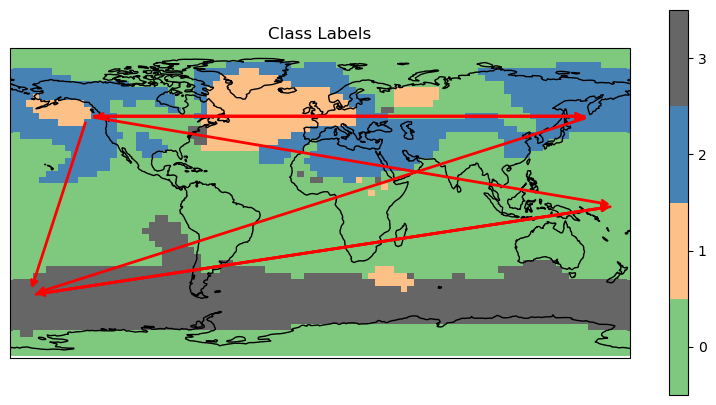

In [140]:
plot_labels(ds_EOFs_GMM, label_var_name='class_label', dpi=100, title_text='Class Labels', causal_links=causal_links)

In [50]:
import random

def plot_labels(ds, label_var_name='class_label', dpi=100, title_text='', causal_links={}):
    sat_label = ds[label_var_name]

    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.Robinson()), dpi=dpi)
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()
    unique_labels = np.unique(sat_label)

    if len(unique_labels) <= 5:
        custom_colors = [
            (0.498, 0.788, 0.498),
            (0.992, 0.753, 0.526),
            (0.941, 0.008, 0.498),
            (0.275, 0.510, 0.706),
            (0.4, 0.4, 0.4),
        ]
        cmap = ListedColormap(custom_colors)
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))

    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False)
    ax.set_global()
    ax.set_title(title_text)

    bounds = np.arange(len(np.unique(sat_label))+1) - 0.5
    ticks = np.arange(len(np.unique(sat_label)))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(np.unique(sat_label))
    cbar.ax.set_ylabel('Class Label')

    # Add causal arrows
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    for source, links in causal_links.items():
        source_lats, source_lons = np.where(sat_label == source)
        for target, _, _, _ in links:
            target_lats, target_lons = np.where(sat_label == target)
            if source_lats.size > 0 and target_lats.size > 0:
                # Select random start and end points
                start_idx = random.choice(range(len(source_lats)))
                end_idx = random.choice(range(len(target_lats)))
                start_lat, start_lon = lat_values[source_lats[start_idx]], lon_values[source_lons[start_idx]]
                end_lat, end_lon = lat_values[target_lats[end_idx]], lon_values[target_lons[end_idx]]

                # Draw an arrow from start to end
                ax.annotate('', xy=(end_lon, end_lat), xycoords='data',
                            xytext=(start_lon, start_lat), textcoords='data',
                            arrowprops=dict(arrowstyle="->", color='red', lw=2))

    plt.show()


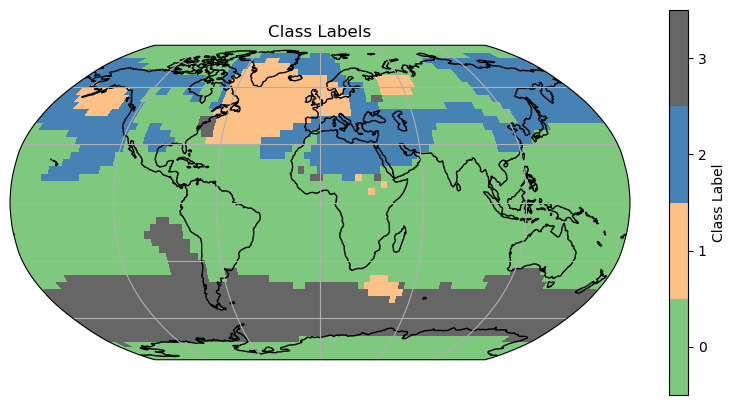

In [51]:
plot_labels(ds_EOFs_GMM, label_var_name='class_label', dpi=100, title_text='Class Labels', causal_links=causal_links)

In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import ListedColormap

def plot_labels(ds,label_var_name='class_label',dpi=100,title_text=''):
    sat_label = ds[label_var_name]

    # colors = ['blue', 'pink', 'green', 'orange', 'purple', 'brown', 'red', 'gray', 'olive', 'cyan']
    
    # create a figure and axis with Robinson projection
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.Robinson()), dpi=dpi)

    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # create colormap with unique colors for each class label
    # cmap = mcolors.ListedColormap(colors[0:len(np.unique(sat_label))])
    unique_labels = np.unique(sat_label)
    # cmap = plt.get_cmap('Accent', len(unique_labels))

    if len(unique_labels) <= 5:
        custom_colors = [
        (0.4980392156862745, 0.788235294117647, 0.4980392156862745),
        (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
        (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
        (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
        (0.4, 0.4, 0.4),
        ]

        # Create a ListedColormap object with your custom colors
        cmap = ListedColormap(custom_colors)   
    else:
        cmap = plt.get_cmap('Accent', len(unique_labels))
    # plot heatmap with Robinson projection
    im = sat_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False)

    # set global extent for Robinson projection
    ax.set_global()
    
    # set title
    ax.set_title(title_text)

    # add colorbar
    bounds = np.arange(len(np.unique(sat_label))+1) - 0.5
    ticks = np.arange(len(np.unique(sat_label)))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(np.unique(sat_label))
    cbar.ax.set_ylabel('Class Label')

    # show plot
    plt.show()

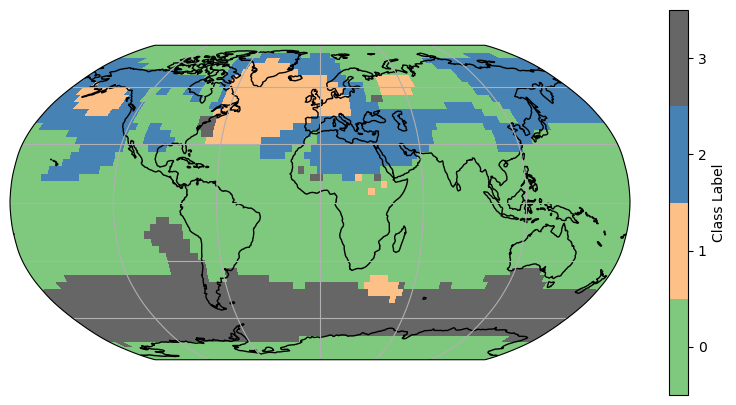

In [34]:
plot_labels(ds_EOFs_GMM)

In [35]:
ds_EOFs_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 -60.7 -60.9 ... -45.53 -45.45
    TREFHT_centered        (age, lat, lon) float32 0.08495 0.09824 ... -0.7201
    weight                 (lat) float64 0.04956 0.1136 ... 0.1136 0.04956
    TREFHT_c_w             (age, lat, lon) float64 0.00421 0.004869 ... -0.03569
    sat_centered           (age, lat, lon) float32 0.08499 0.09825 ... -0.72
    sat_centered_weighted  (age, lat, lon) float64 0.004212 ... -0.03569
    class_label            (lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0>